## Imports and Parameters

In [1]:
import tensorflow as tf
from tensorflow import keras
import pickle
import os
import numpy as np
from NozPiker_Funcs import main as NZ
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cv2
import datetime
from IPython.display import clear_output
from livelossplot import PlotLossesKeras

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [21]:
%load_ext autoreload
%autoreload 2


In [2]:
# Define Data Path
DATA_DIR = '/local/home/rmccool/NozPiker/data/tetts_F15_massSpec_only/' # will need to be changed for all new users. Appropriate files for training and analysis must be moved to this directory as well

# Fetching pdbs and converting to images

In [4]:
MRC_PATHS = glob.glob(DATA_DIR + '*mrcs')

In [5]:
len(MRC_PATHS)

39

In [6]:
def GetImageSet(mrc,store):
    from mrcfile import open
    name = mrc.split('/')[-1].split('_')[0]
    ID = mrc.split('/')[-1].split('_')[1]
    with open(mrc,'r') as m:
        data = []
        for i in range(m.data.shape[0]):
            data.append(m.data[i,:,:])
    size = len(data[-1][:,0])
    for image in range(len(data)):
        store[(name, ID, image)] = data[image]
    return size

In [7]:
store = {}
MXSZ = 0
for MRC in MRC_PATHS:
    size = GetImageSet(MRC,store)
    if size > MXSZ:
        MXSZ = size

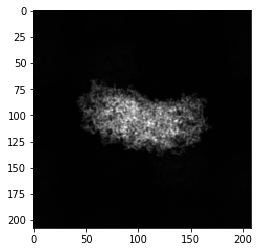

In [7]:
plt.imshow(store[('TUBULIN', '1FFX',4)], cmap=plt.cm.binary_r)
plt.show()

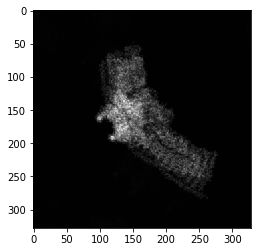

In [8]:
plt.imshow(store[('CLATHRINHEAVYCHAIN', '6SCT', 26)], cmap=plt.cm.binary_r)
plt.show()

In [8]:
def CreateTrainingData(store, size, percent_test):
    from numpy import array, where, zeros, min, max, resize, transpose, floor
    from tensorflow_core.image import resize_with_crop_or_pad
    import random
    # Get Dict keys
    class_names = list(set([key[0] for key in store]))
    # Pre-allocate arrays
    length = 30
    shape = (size,size)
    test_length = int(len(store)*percent_test)
    test_set = dict(random.sample(store.items(), test_length))
    train_set = {key: store[key] for key in store if key not in list(test_set.keys())}
    test_images = []
    test_labels = []
    for k, v in test_set.items():
        array = v
        array = resize(array,(array.shape[0],array.shape[1],1))
        array = resize_with_crop_or_pad(array,size,size)
        array = transpose(array,(2,0,1))
        test_images.append(array)
        test_labels.append(class_names.index(k[0]))

    #test_images = np.asarray(test_images)
    test_images = np.concatenate(test_images)
    test_images = test_images.astype('uint8')
    test_labels = np.asarray(test_labels)
    
    train_images = []
    train_labels = []
    for k, v in train_set.items():
        array = v
        array = resize(array,(array.shape[0],array.shape[1],1))
        array = resize_with_crop_or_pad(array,size,size)
        array = transpose(array,(2,0,1))
        train_images.append(array)
        train_labels.append(class_names.index(k[0]))

    #train_images = np.asarray(train_images)    
    train_images = np.concatenate(train_images)
    train_images = train_images.astype('uint8')
    train_labels = np.asarray(train_labels)
        
    
    return train_images, train_labels, test_images, test_labels, class_names

In [43]:
train_images, train_labels, test_images, test_labels, class_names = CreateTrainingData(store, MXSZ, 0.3)

In [44]:
class_names

['TUBULIN',
 'AMINOACYLTRNASYNTHASECOMPLEXINTERACTINGMULTIFUNCTIONA',
 '60KDAHEATSHOCKPROTEINMITOCHONDRIAL',
 'DYNAMIN1',
 'DYNEIN',
 'ATPDEPENDENTMOLECULARCHAPERONEHSP82',
 'CLATHRINHEAVYCHAIN',
 '26SPROTEASOME']

In [45]:
train_images.shape

(819, 784, 784)

In [46]:
train_images_sm = np.zeros((len(train_images), 100, 100))

for idx in range(len(train_images)):
    img = train_images[idx, :, :]
    img_sm = cv2.resize(img, (100, 100), interpolation=cv2.INTER_CUBIC)
    train_images_sm[idx, :, :] = img_sm

In [47]:
test_images_sm = np.zeros((len(test_images), 100, 100))

for idx in range(len(test_images)):
    img = test_images[idx, :, :]
    img_sm = cv2.resize(img, (100, 100), interpolation=cv2.INTER_CUBIC)
    test_images_sm[idx, :, :] = img_sm

In [48]:
train_images_sm.shape

(819, 100, 100)

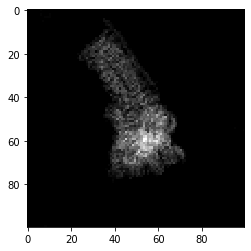

In [36]:
plt.imshow(train_images_sm[100], cmap=plt.cm.binary_r)
plt.show()

In [41]:
train_images_sm = np.asarray(train_images_sm).reshape((819, 100, 100, 1))
test_images_sm = np.asarray(test_images_sm).reshape((351, 100, 100, 1))


In [42]:
test_images_sm.shape

(351, 100, 100, 1)

## Create Model

In [30]:
# Define model
def create_model():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(100,100)),
        keras.layers.Dense(1000,activation='relu'),
        keras.layers.Dense(128,activation='relu'),
        keras.layers.Dense(len(class_names))
    ])
    
    model.compile(optimizer = 'adam',
                  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])
    return model


KeyboardInterrupt: 

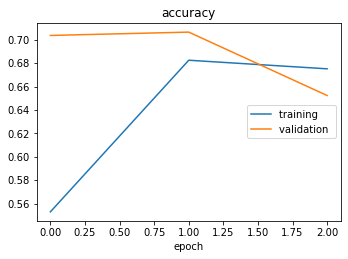

In [43]:
import time

denselayers = [0, 1, 2]
layersizes = [32, 64, 128]
convlayers = [1, 2, 3]

for denselayer in denselayers:
    for layersize in layersizes:
        for convlayer in convlayers:
            NAME = "{}_conv_{}_nodes_{}_dense_{}".format(convlayer, layersize, denselayer, int(time.time()))
            print(NAME)
            
            model = keras.models.Sequential()

            model.add(keras.layers.Conv2D(layersize, (3,3),input_shape=[100,100,1]))
            model.add(keras.layers.Activation('relu'))
            model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

            for l in range(convlayer-1):
                model.add(keras.layers.Conv2D(layersize, (3,3)))
                model.add(keras.layers.Activation('relu'))
                model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

            model.add(keras.layers.Flatten())

            for l in range(denselayer):
                model.add(keras.layers.Dense(layersize))
                model.add(keras.layers.Activation('relu'))
                
            model.add(keras.layers.Dense(len(class_names)))
            model.add(keras.layers.Activation('sigmoid'))
            
            tensorboard = tf.keras.callbacks.TensorBoard(log_dir=DATA_DIR+'logs/{}'.format(NAME))
            
            model.compile(optimizer = 'adam',
                  loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])
            
            model.fit(train_images_sm,
              train_labels,
              epochs=5,
              validation_data = (test_images_sm,test_labels),
              callbacks=[PlotLossesKeras()])

In [31]:
# Create a basic model instance
model = create_model()

# log_dir = "Logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Display the model's architecture
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              10001000  
_________________________________________________________________
dense_13 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 1032      
Total params: 10,130,160
Trainable params: 10,130,160
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [ ]:
train_images = pickle.load(open(DATA_DIR + "train_images.pkl"))
train_labels = pickle.load(open(DATA_DIR + "train_labels.pkl"))
class_names = pickle.load(open(DATA_DIR + "class_names.pkl"))

In [ ]:
import time
NAME = "tetts_basic_nn_{}".format(int(time.time()))

In [32]:
checkpoint_path = os.path.join(os.path.dirname(os.path.dirname(DATA_DIR)),'checkpoints/cp.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)

In [34]:
# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

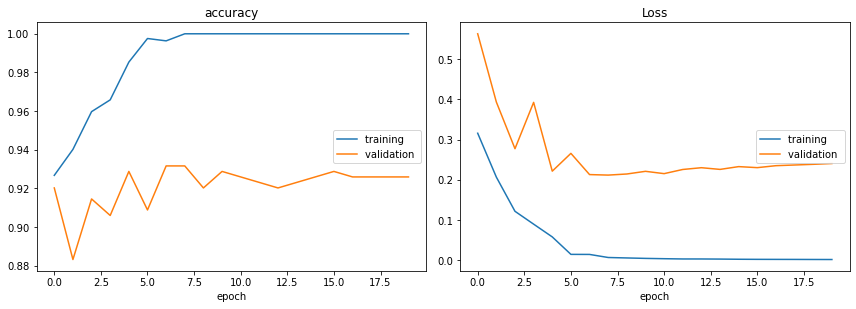

accuracy
	training         	 (min:    0.927, max:    1.000, cur:    1.000)
	validation       	 (min:    0.883, max:    0.932, cur:    0.926)
Loss
	training         	 (min:    0.001, max:    0.316, cur:    0.001)
	validation       	 (min:    0.211, max:    0.563, cur:    0.240)
819/819 [==============================] - 1s 2ms/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2403 - val_accuracy: 0.9259


In [49]:
model.fit(train_images_sm,
          train_labels,
          epochs=20,
          validation_data = (test_images_sm,test_labels),
          callbacks=[PlotLossesKeras()])

In [ ]:
os.path.dirname(os.path.dirname(DATA_DIR))

In [50]:
# Save Model as Hd5
MODEL_DIR = os.path.join(os.path.dirname(os.path.dirname(DATA_DIR)),'models')
model.save(os.path.join(MODEL_DIR,'Multi_Train.h5', 'w'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/cns-mccafferty/NozPiker/data/models/Multi_Train.h5/w/assets


## Load Trained Model

In [3]:
# Load the model
MODEL_DIR = os.path.join(os.path.dirname(os.path.dirname(DATA_DIR)),'models')
model = keras.models.load_model(os.path.join(MODEL_DIR,'Multi_Train.h5', 'w'))

# Prepare Validation Data

In [2]:
VAL_DIR = '/local/home/rmccool/NozPiker/data/tetts_F15_massSpec/validation/' #adjusted for Ryan's directory

In [3]:
MRC_PATHS = glob.glob(VAL_DIR + '*mrcs')

In [6]:
store = {}
MXSZ = 0
for MRC in MRC_PATHS:
    size = GetImageSet(MRC,store)
    #size = NZ.GetImageSet(MRC,store)
    if size > MXSZ:
        MXSZ = size

In [10]:
from numpy import array, where, zeros, min, max, resize, transpose, floor
from tensorflow_core.image import resize_with_crop_or_pad
import random
# Get Dict keys
val_class_names = list(set([key[0] for key in store]))
# Pre-allocate arrays
size= 784
length = 20
shape = (size,size)

val_labels = []
val_images = []
for k, v in store.items():
    array = v
    array = resize(array,(array.shape[0],array.shape[1],1))
    array = resize_with_crop_or_pad(array,size,size)
    array = transpose(array,(2,0,1))
    val_images.append(array)
    val_labels.append(val_class_names.index(k[0]))

#test_images = np.asarray(test_images)
val_images = np.concatenate(val_images)
val_images = val_images.astype('uint8')
#val_labels = np.asarray(test_labels)


In [11]:
val_class_names

['26SPROTEASOME', 'DYNAMIN', 'CLATHRIN']

In [85]:
val_images_sm = np.zeros((len(test_images), 100, 100))


for idx in range(len(val_images)):
    img = val_images[idx, :, :]
    img_sm = cv2.resize(img, (100, 100), interpolation=cv2.INTER_CUBIC)
    val_images_sm[idx, :, :] = img_sm

In [86]:
prediction = model.predict(val_images_sm)

In [87]:
for i in prediction:
    print(class_names[np.argmax(i)])


DYNEIN
TUBULIN
TUBULIN
26SPROTEASOME
DYNAMIN1
26SPROTEASOME
26SPROTEASOME
DYNAMIN1
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
DYNAMIN1
TUBULIN
TUBULIN
TUBULIN
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
DYNAMIN1
TUBULIN
TUBULIN
ATPDEPENDENTMOLECULARCHAPERONEHSP82
DYNAMIN1
26SPROTEASOME
60KDAHEATSHOCKPROTEINMITOCHONDRIAL
AMINOACYLTRNASYNTHASECOMPLEXINTERACTINGMULTIFUNCTIONA
TUBULIN
CLATHRINHEAVYCHAIN
TUBULIN
26SPROTEASOME
CLATHRINHEAVYCHAIN
26SPROTEASOME
TUBULIN
26SPROTEASOME
DYNAMIN1
DYNAMIN1
DYNEIN
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
26SPROTEASOME
CLATHRINHEAVYCHAIN
CLATHRINHEAVYCHAIN
CLATHRINHEAVYCHAIN
CLATHRINHEAVYCHAIN
CLATHRINHEAVYCHAIN
CLATHRINHEAVYCHAIN
CLATHRINHEAVYCHAIN
CLATHRINHEAVYCHAIN
CLATHRINHEAVYCHAIN
CLATH

In [70]:
class_names[13]

'TUBULIN'

In [69]:
MRC_PATHS

['/home/cns-mccafferty/NozPiker/data/tetts_F15_massSpec/validation/26SPROTEASOME_9512_proj.mrcs',
 '/home/cns-mccafferty/NozPiker/data/tetts_F15_massSpec/validation/CLATHRIN_0121_proj.mrcs',
 '/home/cns-mccafferty/NozPiker/data/tetts_F15_massSpec/validation/DYNAMIN_1949_proj.mrcs',
 '/home/cns-mccafferty/NozPiker/data/tetts_F15_massSpec/validation/HEMOGLOBIN_3488_proj.mrcs']

In [58]:
store

{('26SPROTEASOME',
  '9512',
  0): array([[-0.0096561 , -0.00696488, -0.00693196, ..., -0.01536941,
         -0.01234858, -0.01180328],
        [-0.01005303, -0.00747937, -0.0107199 , ..., -0.01649158,
         -0.01516059, -0.01377305],
        [-0.01366294, -0.01135984, -0.01567437, ..., -0.00526282,
         -0.00838616, -0.0138849 ],
        ...,
        [-0.01927074, -0.0143088 , -0.01028086, ..., -0.02026892,
         -0.01606092, -0.01766644],
        [-0.02163274, -0.01559856, -0.01046859, ..., -0.00525078,
         -0.00637733, -0.01636591],
        [-0.01563118, -0.01171362, -0.00820656, ..., -0.00336396,
         -0.00390179, -0.01192068]], dtype=float32),
 ('26SPROTEASOME',
  '9512',
  1): array([[-0.0543773 , -0.0564602 , -0.04252727, ..., -0.05234378,
         -0.03939185, -0.0391735 ],
        [-0.06230298, -0.05904427, -0.04619832, ..., -0.05545073,
         -0.04687693, -0.05118253],
        [-0.05375907, -0.04193369, -0.03848699, ..., -0.05424655,
         -0.04905516